In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # Normalize to [-1, 1]
])

dataloader = DataLoader(
    datasets.MNIST(root="./data", train=True, download=True, transform=transform),
    batch_size=128,
    shuffle=True
)


In [4]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 784),
            nn.Tanh()
        )

    def forward(self, z):
        return self.model(z).view(-1, 1, 28, 28)


In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 512),
            nn.LeakyReLU(0.2),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, img):
        return self.model(img)


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
latent_dim = 100

generator = Generator(latent_dim).to(device)
discriminator = Discriminator().to(device)

criterion = nn.BCELoss()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002)


In [13]:
epochs = 5

for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        batch_size = imgs.size(0)
        real_imgs = imgs.to(device)

        # Labels
        real_labels = torch.ones(batch_size, 1).to(device)
        fake_labels = torch.zeros(batch_size, 1).to(device)

        # Train Generator
        optimizer_G.zero_grad()
        z = torch.randn(batch_size, latent_dim).to(device)
        generated_imgs = generator(z)
        g_loss = criterion(discriminator(generated_imgs), real_labels)
        g_loss.backward()
        optimizer_G.step()

        # Train Discriminator
        optimizer_D.zero_grad()
        real_loss = criterion(discriminator(real_imgs), real_labels)
        fake_loss = criterion(discriminator(generated_imgs.detach()), fake_labels)
        d_loss = (real_loss + fake_loss) / 2
        d_loss.backward()
        optimizer_D.step()

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")


Epoch 1/5 | D Loss: 0.0143 | G Loss: 7.2975
Epoch 2/5 | D Loss: 0.0000 | G Loss: 11.5325
Epoch 3/5 | D Loss: 0.0002 | G Loss: 8.0939
Epoch 4/5 | D Loss: 0.0610 | G Loss: 6.1202
Epoch 5/5 | D Loss: 0.0396 | G Loss: 6.0379


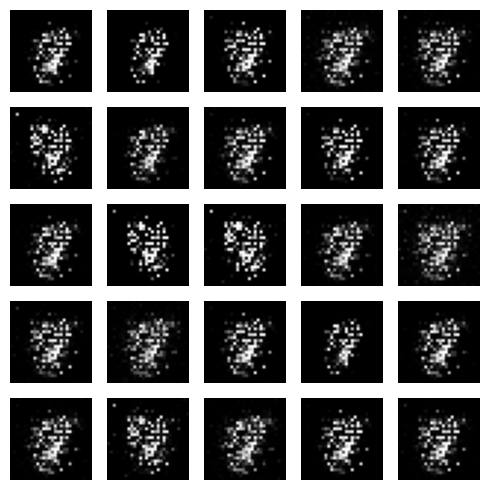

In [18]:
def show_images(generator, latent_dim):
    generator.eval()
    z = torch.randn(25, latent_dim).to(device)
    gen_imgs = generator(z).cpu().detach()

    fig, axs = plt.subplots(5, 5, figsize=(5, 5))
    for i in range(5):
        for j in range(5):
            axs[i, j].imshow(gen_imgs[i*5 + j][0], cmap='gray')
            axs[i, j].axis('off')
    plt.tight_layout()
    plt.show()

show_images(generator, latent_dim)
